In [1]:
import numpy as np
import pandas as pd
import pickle

In [2]:
path = ("C:/Users/Ong Jia Yi/Desktop/STUDY/Summer 2021"
        "/Rotman MMA Summer 2021 Datathon")

load = pd.read_csv(path + "/NWHL.csv")

In [3]:
data = pickle.load(open("DATA_shot_goal_merged.p", "rb"))

In [4]:
X_train_player = data['X_train_player']
X_train_event = data['X_train_event']
y_train = data['y_train']
X_test_player = data['X_test_player']
X_test_event = data['X_test_event']
y_test = data['y_test']

In [5]:
X_train_event.shape

(24191, 63)

In [6]:
X_test_event.shape

(2688, 63)

In [7]:
y_train.shape

(24191,)

## Mixed Data Neural Network

In [8]:
from kerastuner import HyperModel

import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Embedding, Input, Dense,
                                     Dropout, Flatten, concatenate)
from tensorflow.keras import optimizers
from tensorflow.keras import metrics

In [9]:
class Hypermodel(HyperModel):
    def __init__(self, input_shapes, n_players, emb_dim, n_class):
        self.input_shape_1 = input_shapes[0]
        self.input_shape_2 = input_shapes[1]
        self.n_players = n_players
        self.emb_dim = emb_dim
        self.n_class = n_class
        
    def build(self, hp):
        input_1 = Input(shape=self.input_shape_1)
        input_2 = Input(shape=self.input_shape_2)
        
        # BRANCH 1
        branch_1 = Embedding(self.n_players, self.emb_dim, 
                             input_length=self.input_shape_1, trainable=True)(input_1)
        
        branch_1 = Dense(units=hp.Int('branch_11', 
                                      min_value=16, 
                                      max_value=128, 
                                      step=4),
                         activation=hp.Choice('activation_11', 
                                              values=['relu', 'tanh', 'sigmoid'])
                        )(branch_1)
                
        branch_1 = Dense(units=hp.Int('branch_12', 
                                      min_value=16, 
                                      max_value=128, 
                                      step=4),
                         activation=hp.Choice('activation_12', 
                                              values=['relu', 'tanh', 'sigmoid'])
                        )(branch_1)
        
        branch_1 = Dropout(rate=hp.Float('dropout_1',
                                         min_value=0.0,
                                         max_value=0.5,
                                         step=0.05)
                          )(branch_1)
        
        branch_1 = Flatten(data_format=None)(branch_1)
        
        branch_1 = Model(inputs=input_1, outputs=branch_1)
        
        # BRANCH 2
        branch_2 = Dense(units=hp.Int('branch_21', 
                                      min_value=16, 
                                      max_value=128, 
                                      step=4),
                         activation=hp.Choice('activation_21', 
                                              values=['relu', 'tanh', 'sigmoid'])
                        )(input_2)
                
        branch_2 = Dense(units=hp.Int('branch_22', 
                                      min_value=16, 
                                      max_value=128, 
                                      step=4),
                         activation=hp.Choice('activation_22', 
                                              values=['relu', 'tanh', 'sigmoid'])
                        )(branch_2)
        branch_2 = Dropout(rate=hp.Float('dropout_2',
                                         min_value=0.0,
                                         max_value=0.5,
                                         step=0.05)
                          )(branch_2)
        
        branch_2 = Model(inputs=input_2, outputs=branch_2)
        
        # COMBINED BRANCH
        input_combined = concatenate([branch_1.output, branch_2.output])
        
        branch_c = Dense(units=hp.Int('branch_c1', 
                                      min_value=16, 
                                      max_value=128, 
                                      step=4),
                         activation=hp.Choice('activation_c', 
                                              values=['relu', 'tanh', 'sigmoid'])
                        )(input_combined)
        
        branch_c = Dense(units=hp.Int('branch_c2', 
                                      min_value=16, 
                                      max_value=128, 
                                      step=4),
                         activation=hp.Choice('activation_c', 
                                              values=['relu', 'tanh', 'sigmoid'])
                        )(branch_c)
        
        branch_c = Dropout(rate=hp.Float('dropout_c',
                                         min_value=0.0,
                                         max_value=0.5,
                                         step=0.05)
                          )(branch_c)
        
        if self.n_class == 2:
            units, activation = (1, 'sigmoid')
            loss, metric = ('binary_crossentropy', [metrics.BinaryAccuracy()])
        elif isinstance(self.n_class, int) & self.n_class > 2:
            units, activation = (self.n_class, 'softmax')
            loss, metric = ('categorical_crossentropy', [metrics.CategoricalAccuracy()])
        else:
            return "Invalid input for <n_class>"
            
        branch_c = Dense(units=units, activation=activation)(branch_c)
        
        model = Model(inputs=[branch_1.input, branch_2.input], outputs=branch_c)
        
        model.compile(
            optimizer=optimizers.Adam(
                learning_rate=hp.Float('learning_rate', 
                                       min_value=1e-4, 
                                       max_value=1e-2,
                                       sampling='LOG')
            ),
            loss=loss, metrics=metric + [metrics.AUC(), metrics.TruePositives()]
        )
        
        return model

In [10]:
input_shape = [(X_train_player.shape[1],), (X_train_event.shape[1],)]
n_players = len(load.Player.unique())
emb_dim = 50
n_class = 2

hypermodel = Hypermodel(input_shape, n_players, emb_dim, n_class)

## Hyperparameter Tuning

In [11]:
import kerastuner
from kerastuner.tuners import RandomSearch
from keras.callbacks import EarlyStopping

In [12]:
tuner = RandomSearch(
    hypermodel,
    objective=kerastuner.Objective("val_true_positives", direction="max"),
    seed=1,
    max_trials=200,
    executions_per_trial=2,
    directory='random_search',
    overwrite=True
)

stop_early = EarlyStopping(monitor='val_true_positives', mode='max',
                           patience=100, restore_best_weights=True)

In [13]:
tuner.search_space_summary()

Search space summary
Default search space size: 15
branch_11 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 4, 'sampling': None}
activation_11 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
branch_12 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 4, 'sampling': None}
activation_12 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
branch_21 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 4, 'sampling': None}
activation_21 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
branch_22 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 4, 'sampling': None}
activation

In [14]:
# N_EPOCH_SEARCH = 300
# tuner.search([np.array(X_train_player), np.array(X_train_event)], y_train, 
#              epochs=N_EPOCH_SEARCH, validation_split=0.3,
#              callbacks=[stop_early])
# pickle.dump(tuner, open("tuner_300_137_2.p", "wb"))

In [15]:
tuner = pickle.load(open("tuner_300_137_2.p", "rb"))

In [16]:
tuner.results_summary(1)

Results summary
Results in random_search\untitled_project
Showing 1 best trials
Objective(name='val_true_positives', direction='max')
Trial summary
Hyperparameters:
branch_11: 92
activation_11: relu
branch_12: 128
activation_12: relu
dropout_1: 0.4
branch_21: 84
activation_21: sigmoid
branch_22: 76
activation_22: tanh
dropout_2: 0.45
branch_c1: 104
activation_c: relu
branch_c2: 28
dropout_c: 0.30000000000000004
learning_rate: 0.0001420663669772626
Score: 201.0


## Tune Optimal Epochs

In [17]:
best_hyppar = tuner.get_best_hyperparameters(num_trials=1)[0]
# final_model = tuner.hypermodel.build(best_hyppar)
# history = final_model.fit([X_train_player, X_train_event], y_train, epochs=500, validation_split=0.3)
# pickle.dump(history.history, open("history_300_137_2.p", "wb"))

In [18]:
history = pickle.load(open("history_300_137_2.p", "rb"))

In [19]:
path2 = ("C:/Users/Ong Jia Yi/Desktop/STUDY/Summer 2021"
        "/Rotman MMA Summer 2021 Datathon/Player Embedding")

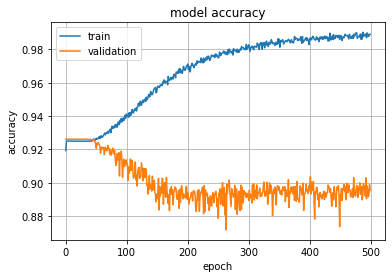

In [20]:
import matplotlib.pyplot as plt

plt.plot(history['binary_accuracy'])
plt.plot(history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.savefig(path2 + "/img_accuracy.png")
plt.show()

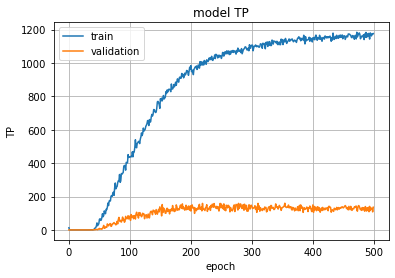

In [21]:
plt.plot(history['true_positives'])
plt.plot(history['val_true_positives'])
plt.title('model TP')
plt.ylabel('TP')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.savefig(path2 + "/img_TP.png")
plt.show()

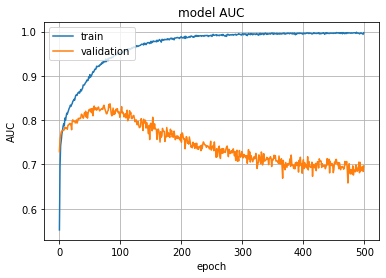

In [22]:
plt.plot(history['auc'])
plt.plot(history['val_auc'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.savefig(path2 + "/img_TP.png")
plt.show()

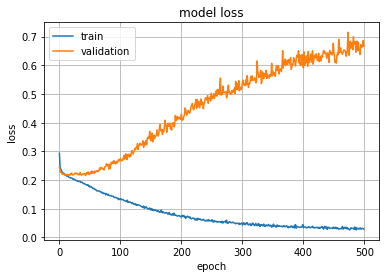

In [23]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.savefig(path2 + "/img_loss.png")
plt.show()

## Final Model

In [24]:
# optimal_epoch = 200
# final_model = tuner.hypermodel.build(best_hyppar)
# final_model.fit([X_train_player, X_train_event], y_train, epochs=optimal_epoch, validation_split=0.3)
# final_model.save(path2)

In [25]:
final_model = keras.models.load_model(path2)

In [26]:
np.sum(y_test)

179.0

In [27]:
loss, acc, auc, TP = final_model.evaluate([X_test_player, X_test_event], y_test)

84/84 [==============================] - 1s 2ms/step - loss: 0.3559 - binary_accuracy: 0.8981 - auc: 0.8128 - true_positives: 49.0000


#### Manual Computation of Metrics

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

In [29]:
probs = final_model.predict([X_test_player, X_test_event])
pred = (probs >= 0.5).astype('uint8')

a = accuracy_score(y_test, pred)
b = roc_auc_score(y_test, probs)
print("Accuracy: {} | AUC: {}".format(round(a, 4), round(b,4 )))

Accuracy: 0.8981 | AUC: 0.8593


In [30]:
cm = confusion_matrix(y_test, pred)
cm

array([[2365,  144],
       [ 130,   49]], dtype=int64)

In [31]:
sens = cm[1,1] / (cm[1,0] + cm[1,1])
spec = cm[0,0] / (cm[0,0] + cm[0,1])
print("Sensitivity: {} | Specificity: {}".format(sens, spec))

Sensitivity: 0.2737430167597765 | Specificity: 0.9426066161817457


In [32]:
fpr, tpr, thresholds = roc_curve(y_test, probs)

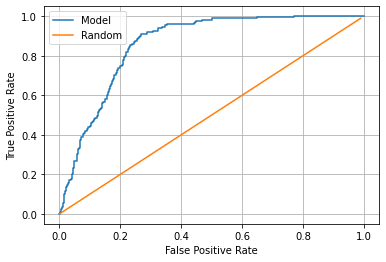

In [33]:
plt.plot(fpr, tpr, label="Model")
plt.plot(np.arange(0,1,0.01), np.arange(0,1,0.01), label="Random")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

## Player Embeddings

In [34]:
# run or load
# embs = final_model.layers[1].get_weights()[0]
# pickle.dump(embs, open("embs_300_137_2.p", "wb"))
# np.savetxt("player_embeddings.csv", embs, delimiter=",")

embs = pickle.load(open("embs_300_137_2.p", "rb"))

In [35]:
embs.shape

(126, 50)

In [36]:
from sklearn.metrics.pairwise import cosine_similarity
import random

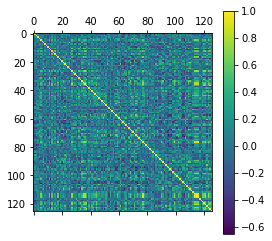

In [37]:
cos_sim = cosine_similarity(embs)
plt.matshow(cos_sim)
plt.colorbar()
plt.show()

In [38]:
np.savetxt("cosine_similarity.csv", cos_sim, delimiter=",")

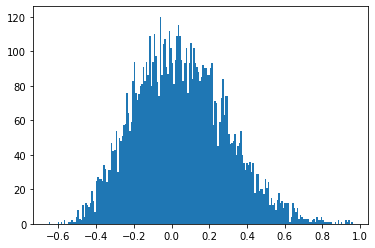

In [39]:
upp_tri = np.triu_indices(cos_sim.shape[0], 1)
plt.hist(cos_sim[upp_tri], bins=200)
plt.show()

### Interpret Embedding

In [40]:
all_players = list(load.Player.unique())
pd.DataFrame(all_players, columns=['player']).to_csv('player_order.csv', index=False)

In [41]:
def get_player_with_affinity(affinity, cos_sim, threshold):
    """Get a player pair within +/- threshold of the given affinity.
    If more than one pair, randomly selects a pair."""
    upp_tri_indx = np.triu_indices(cos_sim.shape[0], 1)
    upp_tri = cos_sim[upp_tri_indx]
    
    if isinstance(affinity, float):
        all_indx = np.where((upp_tri < affinity + threshold) & (upp_tri > affinity - threshold))[0]
        indx = random.choice(all_indx)
    elif affinity == "max":
        indx = np.argmax(upp_tri)
    elif affinity == "min":
        indx = np.argmin(upp_tri)
    else:
        return "Invalid affinity value. Input a float or 'min', 'max'"

    p1 = all_players[upp_tri_indx[0][indx]]
    p2 = all_players[upp_tri_indx[1][indx]]
    t1 = load.Team[load.Player == p1].unique()[0]
    t2 = load.Team[load.Player == p2].unique()[0]
    print("{} ({}) & {} ({}) has affinity {}".format(p1, t1, p2, t2, upp_tri[indx]))

In [42]:
get_player_with_affinity('max', cos_sim, 0.01)

Victoria Hanson (Boston Pride) & Tera Hofmann (Metropolitan Riveters) has affinity 0.9620693325996399


In [43]:
def get_affinity(player_1, player_2, cos_sim):
    """Returns the cosine similarity between the vector embeddings
    of <player_1> and <player_2>.
    
    Arguments:
    player_1, player_2 -- names of player 1 and 2
    cos_sim -- cosine similarity matrix
    """
    id_1 = all_players.index(player_1)
    id_2 = all_players.index(player_2)
    
    return cos_sim[id_1, id_2]

In [44]:
get_affinity('Lauren Kelly', 'Taylor Woods', cos_sim)

-0.15034693

In [45]:
affs = []
names = []
for i in all_players:
    a = get_affinity('McKenna Brand', i, cos_sim)
    affs.append(a)
    names.append(i)
pd.DataFrame({'Name': names, 'Affinity': affs}).sort_values('Affinity', ascending=False)

,Name,Affinity
1,McKenna Brand,1.000000
86,Jayne Lewis,0.425659
52,Katelynn Russ,0.365807
100,Taytum Clairmont,0.361523
88,Breanne Wilson-Bennett,0.349841
...,...,...
51,Dominique Kremer,-0.343545
73,Cassidy MacPherson,-0.347436
64,Kaycie Anderson,-0.376530
118,Laurel Hill,-0.456280


In [46]:
def analogy(a, b, c):
    """a is to b as c is to x
    """

    a_vec = embs[all_players.index(a),:]
    b_vec = embs[all_players.index(b),:]
    c_vec = embs[all_players.index(c),:]
    
    diffs = []
    players = []
    for player in all_players:
        x_vec = embs[all_players.index(player),:]
        diff = np.sum((b_vec - a_vec + c_vec - x_vec)**2)
        diffs.append(diff)
        players.append(player)

    return pd.DataFrame({'diff': diffs, 'player': players}).sort_values('diff')

In [47]:
analogy('Paige Capistran', 'Lauren Kelly', 'Kaleigh Fratkin').sort_values('diff')

,diff,player
18,0.606747,Lauren Kelly
72,0.639996,Brittany Colton
85,0.649190,Kelly Babstock
58,0.763308,Kayla Meneghin
9,0.784061,Kaleigh Fratkin
...,...,...
123,4.908947,Maeve Reilly
77,5.147970,Sonjia Shelly
116,5.251658,Samantha Ridgewell
115,5.512016,Tera Hofmann
